# GLMMs to predict syllable probability

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.spatial import distance_matrix, distance
from skbio.stats.composition import clr, closure, multi_replace
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM  as binomial

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
# from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

# DATA

In [3]:
# Get timing info
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')

In [4]:
# states_file['trial_type'] = states_file['correct'].astype(str) + states_file['choice'].astype(str) + states_file['contrast'].astype(str) + states_file['block'].astype(str)
states_file['trial_type'] = states_file['correct'].astype(str) + states_file['choice'].astype(str)
syllable_df = states_file[['mouse_name', 'session', 'most_likely_states', 'trial_type', 'trial_id', 'broader_label']]

In [81]:
# states_file['trial_type'] = states_file['correct'].astype(str) + states_file['choice'].astype(str) + states_file['contrast'].astype(str) + states_file['block'].astype(str)
states_file['trial_type'] = states_file['correct'].astype(str) + states_file['choice'].astype(str)
syllable_df = states_file[['mouse_name', 'session', 'most_likely_states', 'trial_type', 'trial_id', 'broader_label']]

In [82]:
metadata = pd.read_parquet( prefix + 'representation_learning_variability/paper-individuality/fig5_mixed_models/metadata_01-11-2026')
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
cluster_df = pd.read_parquet(data_path+'5_mouse_cluster_coef')

In [31]:
# cluster_df = pd.read_parquet(data_path+'8_cluster_per_mouse_trial')

In [83]:
syllable_df = syllable_df.merge(metadata[['session', 'lab']])
syllable_df = syllable_df.merge(cluster_df[['mouse_name', 'mouse_cluster']], on='mouse_name', how='outer')

In [76]:
mice = syllable_df.mouse_name.unique()
dob = pd.DataFrame(columns=['mouse_name', 'dob'], index=range(len(mice)))
for s, mouse in enumerate(mice):
    subject_info = one.alyx.rest('subjects', 'read', id=mouse)
    date_of_birth = subject_info.get('birth_date')
    dob['mouse_name'][s] = mouse
    dob['dob'][s] = date_of_birth

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18499/2017033007.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dob['mouse_name'][s] = mouse
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18499/2017033007.py:7: Fu

In [84]:
syllable_df = syllable_df.merge(dob[['mouse_name', 'dob']])

In [85]:
len(syllable_df.mouse_name.unique())

46

### Minimum number of sessions per mouse

In [86]:
session_count = syllable_df[['mouse_name', 'session']].drop_duplicates().groupby(['mouse_name'])['session'].count().reset_index()
multi_sess_mice = session_count.loc[session_count['session']>2, 'mouse_name']
syllable_df = syllable_df.loc[syllable_df['mouse_name'].isin(multi_sess_mice)]

### Minimum number of trials per mouse and unique trials

In [87]:
tria = syllable_df[['mouse_name', 'session', 'trial_id']].drop_duplicates()
min_trial = np.min(tria.groupby(['mouse_name'])['trial_id'].count())

syllable_df = syllable_df.sort_values(["mouse_name", "session", "trial_id"])
syllable_df["trial_global"] = (syllable_df.groupby(["mouse_name", "session", "trial_id"]).ngroup())

In [88]:
print(min_trial)

1386


In [89]:
def subsample_trials_per_mouse(df, n_trials, random_state=None):
    rng = np.random.default_rng(random_state)

    sampled_trials = (df[["mouse_name", "trial_global"]]
                      .drop_duplicates().groupby("mouse_name")
                      .apply(lambda x: x.sample(n=min(n_trials, len(x)), replace=False,
                        random_state=rng.integers(1e9))).reset_index(drop=True))

    return df.merge(sampled_trials, on=["mouse_name", "trial_global"])


## Predict syllable x epoch 
- no trial type
- for clustering of mice

In [39]:
group_cols = ['mouse_name', 'session', 'broader_label', 'lab', 'mouse_cluster', 'trial_type']

# Count syllables per group
data = (
    syllable_df
    .groupby(group_cols + ['most_likely_states'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session', 'lab', 'mouse_cluster', 'trial_type']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['most_likely_states', 'broader_label']).reset_index().fillna(0)


In [40]:
df = pd.DataFrame()
df['mouse_name'] = data.mouse_name
df['mouse_cluster'] = data.mouse_cluster
df['trial_type'] = data.trial_type
df['lab'] = data.lab
df['lab_mouse'] = data.lab + data.mouse_name
df['session'] = data.session

syll = syllable_df.most_likely_states.astype(str) + syllable_df.broader_label
syll = syll.unique()
syll = data.keys()[5:]

y = data.drop(['mouse_name',  'lab', 'session', 'mouse_cluster', 'trial_type'], axis=1).to_numpy()  # , 'broader_label'
y_log = np.log(y + 1e-6)
y = (y_log - y_log.mean(axis=0, keepdims=True)) / y_log.std(axis=0, keepdims=True)


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18499/1674904468.py:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y = data.drop(['mouse_name',  'lab', 'session', 'mouse_cluster', 'trial_type'], axis=1).to_numpy()  # , 'broader_label'


In [41]:
results = pd.DataFrame(columns=['syllable', 'mouse_var', 'lab_var', 'resid_var', 'converged'], index=range(len(syll)))

formula = 'syll ~ mouse_name'
vc_form = {'lab': '0 + C(lab)'}

groups = df['session']
# groups = pd.Series(np.zeros(len(df)))  # dummy
# vc_form = {'lab': '0 + C(lab)',
#         'mouse_name': '0 + C(mouse_name)'}
# vc_form = {'mouse_cluster': '0 + C(mouse_cluster)',
#            'lab': '0 + C(lab)',
#            }

for i, sy in enumerate(range(127)):
    df['syll'] = y[:, i]
    model = smf.mixedlm(
        formula,
        data=df,
        groups=groups, 
        vc_formula=vc_form
        )
    res = model.fit()

    # Group variance
    var_mouse = res.cov_re.iloc[0,0] if res.cov_re.shape[0] > 0 else 0
    # var_mouse = res.vcomp[0] if len(res.vcomp) > 0 else 0
    # Lab variance
    var_lab = res.vcomp[0] if len(res.vcomp) > 0 else 0
    # Litter variance
    var_litter = res.vcomp[1] if len(res.vcomp) > 0 else 0
    # Residual variance
    var_resid = res.scale

    results['syllable'][i]= i
    results['mouse_var'][i]= var_mouse
    results['lab_var'][i]= var_lab
    results['resid_var'][i]= var_resid
    results['converged'][i] = res.converged

    # print(res.summary())

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18499/362656361.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  results['syllable'][i]= i
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18499/362656361.py:33: Futur

In [36]:
def fit_lmm(df, y, syll, formula, groups, vc_form):
    results = pd.DataFrame(columns=['syllable', 'group_var', 'lab_var', 'resid_var', 'converged'], index=range(len(syll)))

    for i, sy in enumerate(syll):
        df['syll'] = y[:, i]
        model = smf.mixedlm(
            formula,
            data=df,
            groups=groups,
            vc_formula=vc_form #, vc_formula=vc_form
            )
        res = model.fit()

        # Group variance
        var_mouse = res.cov_re.iloc[0,0] if res.cov_re.shape[0] > 0 else 0
        # var_mouse = res.vcomp[1] if len(res.vcomp) > 0 else 0
        # Lab variance
        var_lab = res.vcomp[0] if len(res.vcomp) > 0 else 0
        # Residual variance
        var_resid = res.scale

        results['syllable'][i]= sy
        results['group_var'][i]= var_mouse
        results['lab_var'][i]= var_lab
        results['resid_var'][i]= var_resid
        results['converged'][i] = res.converged

        # print(res.summary())
    return results

In [37]:
repeats = 2
all_results = pd.DataFrame()

formula = 'syll ~ 1'
groups = pd.Series(np.zeros(len(df)))  # dummy
vc_form = {'lab': '0 + C(lab)',
        'mouse_name': '0 + C(mouse_name)'}
vc_form = {'mouse_cluster': '0 + C(mouse_cluster)',
           'lab': '0 + C(lab)'}
vc_form = {'lab': '0 + C(lab)'}
for r in range(repeats):
    print('Repeat %d of %d' % (r+1, repeats))  

    # Subsample data anew
    subsampled = subsample_trials_per_mouse(syllable_df, min_trial, random_state=None)
    # Count syllables per group
    group_cols = ['mouse_name', 'session', 'broader_label', 'lab', 'mouse_cluster']
    data = (subsampled
        .groupby(group_cols + ['most_likely_states'])
        .size().reset_index(name='count'))

    # Convert counts to fractions within each group
    data['usage'] = (
        data['count'] /
        data.groupby(group_cols)['count'].transform('sum'))

    group_cols = ['mouse_name', 'session', 'lab', 'mouse_cluster']
    data = pd.pivot_table(data, values='usage', index=group_cols, columns=['most_likely_states', 'broader_label']).reset_index().fillna(0)

    df = pd.DataFrame()
    df['mouse_name'] = data.mouse_name
    df['mouse_cluster'] = data.mouse_cluster
    # df['type'] = data.trial_type
    df['lab'] = data.lab
    df['lab_mouse'] = data.lab + data.mouse_name
    # df['finger'] = data.mouse_cluster
    df['session'] = data.session

    syll = syllable_df.most_likely_states.astype(str) + syllable_df.broader_label
    syll = syll.unique()
    syll = np.array(data.keys()[4:])
    
    y = data.drop(['mouse_name', 'lab', 'session', 'mouse_cluster'], axis=1).to_numpy()  # , 'broader_label'
    y_log = np.log(y + 1e-6)
    y = (y_log - y_log.mean(axis=0, keepdims=True)) / y_log.std(axis=0, keepdims=True)

    # Fit LMM
    groups = df['session']
    results = fit_lmm(df, y, syll, formula, groups, vc_form)
    results['repeat'] = r

    # Save results
    all_results = pd.concat([all_results, results])
    
    # # Save results
    # samplings_df.loc[r, 'repeat'] = r
    # samplings_df.loc[r, 'distance_matrix'] = pairwise_matrix


Repeat 1 of 2


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18499/2801606035.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(n_trials, len(x)), replace=False,
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18499/4100138132.py:43: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y = data.drop(['mouse_name', 'lab', 'session', 'mouse_cluster'], axis=1).to_numpy()  # , 'broader_label'
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  war

LinAlgError: Singular matrix

In [19]:
all_results[['syllable', 'epoch']] = pd.DataFrame(all_results['syllable'].tolist(), index=all_results.index)


In [20]:
identifiable_mapping = {'000': 0.0,
           '100': 1.0,
           '200': 2.0,
           '300': 3.0,
           '400': 4.0,
           '500': 5.0,
           '600': 6.0,
           '700': 7.0,
           
           '010': 8.0,
           '110': 9.0,
           '210': 10.0,
           '310': 11.0,
           '410': 12.0,
           '510': 13.0,
           '610': 14.0,
           '710': 15.0,

           '001': 16.0,
           '101': 17.0,
           '201': 18.0,
           '301': 19.0, 
           '401': 20.0, 
           '501': 21.0, 
           '601': 22.0, 
           '701': 23.0, 

           '011': 24.0,
           '111': 25.0,
           '211': 26.0,
           '311': 27.0,
           '411': 28.0,
           '511': 29.0,
           '611': 30.0,
           '711': 31.0,
           'nan': np.nan
           }
    # paw_mapping = {0:4, 1:1, 2:5, 3:7, 4:6, 5:2, 6:0, 7:3}
inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
replace_func = np.vectorize(inverted_mapping.get)

In [21]:
all_results['mouse_icc'] = all_results['mouse_var']/(all_results['mouse_var']+all_results['lab_var']+all_results['resid_var'])
all_results['lab_icc'] = all_results['lab_var']/(all_results['mouse_var']+all_results['lab_var']+all_results['resid_var'])

In [22]:
var_df = all_results.copy()
var_df = all_results.loc[all_results['converged']==True]
var_df['identifiable_states'] = replace_func(var_df['syllable'])
var_df = pd.melt(var_df, id_vars=['repeat', 'epoch', 'identifiable_states'], value_vars=['mouse_icc', 'lab_icc'])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7204/3326707411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_df['identifiable_states'] = replace_func(var_df['syllable'])


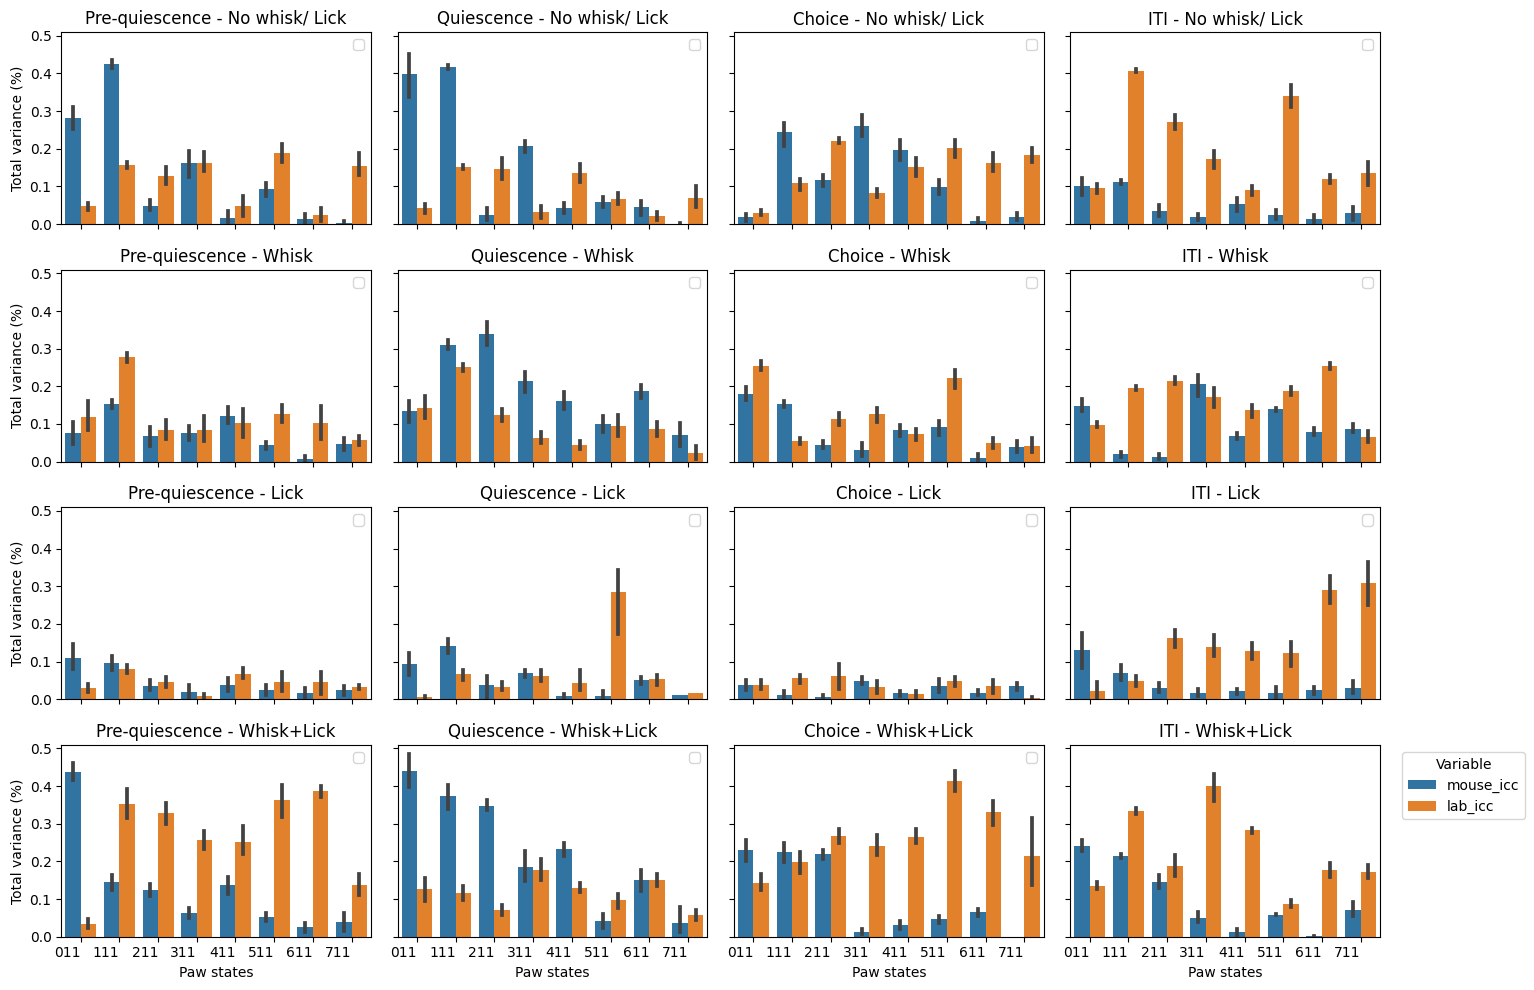

In [23]:
syllable_labels = [['000', '100', '200', '300', '400', '500', '600', '700'],
                   ['010', '110', '210', '310', '410', '510', '610', '710'],
                   ['001', '101', '201', '301', '401', '501', '601', '701'],
                   ['011', '111', '211', '311', '411', '511', '611', '711']]

titles = ['No whisk/ Lick', 'Whisk', 'Lick', 'Whisk+Lick']
epochs = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

fig, axes = plt.subplots(4, 4, figsize=(14, 10), sharey=True, sharex=True)

for i in range(4):
    use_syllables = syllable_labels[i]
    use = var_df.loc[var_df['identifiable_states'].isin(use_syllables)]
    for e, epoch in enumerate(epochs):
        use_data = use.loc[use['epoch']==epoch]
        sns.barplot(
            data=use_data,
            x="identifiable_states",
            y="value",
            hue="variable",
            ax=axes[i, e])
        
        axes[i, e].set_xticks(range(len(use_syllables)))  # or specify labels explicitly if needed
        axes[3, e].set_xticklabels(use_syllables, ha='right')
        if e == 0:
            axes[i, e].set_ylabel("Total variance (%)")
        else:
            axes[i, e].set_ylabel("")
        axes[i, e].set_title(epoch+' - '+titles[i])  # optional title per subplot
        axes[i, e].legend('')
        axes[i, e].set_xlabel('')
        axes[3, e].set_xlabel("Paw states")
# Optional: adjust layout and legend
plt.tight_layout()
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [47]:
total_var = var_mouse + var_lab + var_resid
icc_mouse = var_mouse / total_var
icc_lab = var_lab / total_var
icc_mouse_lab = (var_mouse + var_lab) / total_var

## Per trial

In [ ]:
# group_cols = ['mouse_name', 'session', 'broader_label', 'lab', 'mouse_cluster', 'trial_id', 'trial_type']
# group_cols = ['mouse_name', 'session', 'broader_label', 'lab', 'mouse_cluster',  'trial_type']
# group_cols = ['mouse_name', 'session', 'broader_label', 'lab', 'mouse_cluster']

# # Count syllables per group
# data = (
#     syllable_df
#     .groupby(group_cols + ['most_likely_states'])
#     .size()
#     .reset_index(name='count'))

# # Convert counts to fractions within each group
# data['usage'] = (
#     data['count'] /
#     data.groupby(group_cols)['count'].transform('sum'))

In [ ]:
group_cols = ['mouse_name', 'session', 'broader_label', 'lab', 'mouse_cluster', 'trial_type', 'trial_id']
# group_cols = ['mouse_name', 'session', 'broader_label', 'lab', 'dob', 'mouse_cluster']

# Count syllables per group
data = (
    syllable_df
    .groupby(group_cols + ['most_likely_states'])
    .size()
    .reset_index(name='count'))

# Convert counts to fractions within each group
data['usage'] = (
    data['count'] /
    data.groupby(group_cols)['count'].transform('sum'))

group_cols = ['mouse_name', 'session', 'lab', 'mouse_cluster', 'trial_id',  'trial_type']
# group_cols = ['mouse_name', 'session', 'lab', 'dob', 'mouse_cluster']
data = pd.pivot_table(data, values='usage', index=group_cols, columns=['most_likely_states', 'broader_label']).reset_index().fillna(0)

In [110]:
data = data.sort_values(by=['lab', 'mouse_cluster', 'mouse_name', 'session', 'trial_type', 'trial_id'])
# data = data.sort_values(by=['lab', 'mouse_cluster', 'mouse_name', 'dob',  'session'])

In [119]:
df = pd.DataFrame()
df['mouse_name'] = data.mouse_name
df['mouse_cluster'] = data.mouse_cluster
df['trial_type'] = data.trial_type
df['lab'] = data.lab
df['lab_mouse'] = data.lab + data.mouse_name
df['session'] = data.session
# df['dob'] = data.dob

syll = syllable_df.most_likely_states.astype(str) + syllable_df.broader_label
syll = syll.unique()
syll = data.keys()[5:]

y = data.drop(['mouse_name',  'lab', 'session', 'mouse_cluster', 'trial_type'], axis=1).to_numpy()  # , 'broader_label'
# y = data.drop(['mouse_name',  'lab', 'session', 'dob', 'mouse_cluster'], axis=1).to_numpy()  # , 'broader_label'
y_log = np.log(y + 1e-6)
y = (y_log - y_log.mean(axis=0, keepdims=True)) / y_log.std(axis=0, keepdims=True)

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18499/2544365830.py:14: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y = data.drop(['mouse_name',  'lab', 'session', 'mouse_cluster', 'trial_type'], axis=1).to_numpy()  # , 'broader_label'


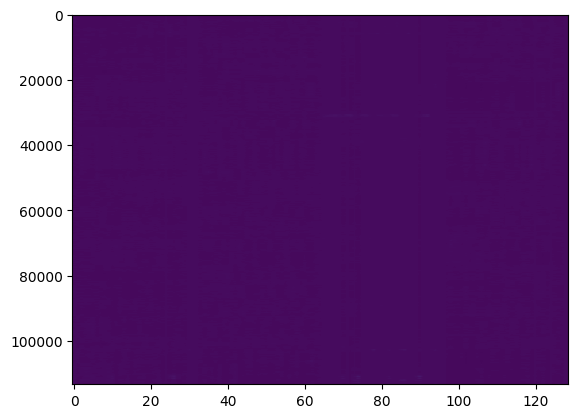

In [117]:
plt.imshow(y, aspect='auto')

In [120]:
# results = pd.DataFrame(columns=['syllable', 'coeffs', 'p_value', 'session_var', 'lab_var', 'resid_var', 'converged'], index=range(len(syll)))
all_results = pd.DataFrame()
formula = 'syll ~ C(trial_type) + C(mouse_name)'# + C(trial_type):C(mouse_name)'
# formula = 'syll ~ C(mouse_name)'# + C(trial_type):C(mouse_name)'
vc_form = {'lab_mouse': '0 + C(lab_mouse)'}
vc_form = {'lab': '0 + C(lab)',
           'litter': '0 + C(dob)'}
vc_form = {'lab': '0 + C(lab)'}

groups = df['session']
# groups = pd.Series(np.zeros(len(df)))  # dummy
# vc_form = {'mouse_cluster': '0 + C(mouse_cluster)'}

for i, sy in enumerate(syll):
    df['syll'] = y[:, i]

    model = smf.mixedlm(
        formula,
        data=df,
        groups=groups) #, 
        # vc_formula=vc_form) #
    res = model.fit()

    # Mouse variance
    # var_mouse = res.cov_re.iloc[0,0] if res.cov_re.shape[0] > 0 else 0
    # var_mouse = res.vcomp[0] if len(res.vcomp) > 0 else 0
    var_session = res.cov_re.iloc[0,0] if res.cov_re.shape[0] > 0 else 0
    # Lab variance
    var_lab = res.vcomp[0] if len(res.vcomp) > 0 else 0
    # var_litter = res.vcomp[1] if len(res.vcomp) > 0 else 0
    # Residual variance
    var_resid = res.scale

    results = pd.concat([res.fe_params , res.pvalues], axis=1).reset_index()
    results = results.rename(columns={0: 'coeffs', 1:'p_value'})[4:-1]
    results['syl'] = str(sy)
    results['syllable']= sy[0]
    results['epoch']= sy[1]
    results['session_var']= var_session
    results['lab_var'] = var_lab
    # results['litter_var'] = var_litter
    results['resid_var'] = var_resid
    results['converged']  = res.converged

    all_results = pd.concat([all_results, results])
    # print(res.summary())

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge

KeyboardInterrupt: 

In [ ]:
all_results

,index,coeffs,p_value,syl,syllable,epoch,session_var,lab_var,litter_var,resid_var,converged
4,C(mouse_name)[T.DY_018],0.149265,0.784518,"(0.0, 'Choice')",0.0,Choice,0.346867,0,0.134657,0.346867,True
5,C(mouse_name)[T.DY_020],0.505245,0.168109,"(0.0, 'Choice')",0.0,Choice,0.346867,0,0.134657,0.346867,True
6,C(mouse_name)[T.NR_0019],0.175937,0.750387,"(0.0, 'Choice')",0.0,Choice,0.346867,0,0.134657,0.346867,True
7,C(mouse_name)[T.NR_0020],0.129209,0.791930,"(0.0, 'Choice')",0.0,Choice,0.346867,0,0.134657,0.346867,True
8,C(mouse_name)[T.NR_0021],0.543222,0.308923,"(0.0, 'Choice')",0.0,Choice,0.346867,0,0.134657,0.346867,True
...,...,...,...,...,...,...,...,...,...,...,...
34,C(mouse_name)[T.ZFM-01935],-0.328907,0.471474,"(31.0, 'Quiescence')",31.0,Quiescence,0.409101,0,0.134657,0.409101,True
35,C(mouse_name)[T.ZFM-01936],-0.948950,0.016189,"(31.0, 'Quiescence')",31.0,Quiescence,0.409101,0,0.134657,0.409101,True
36,C(mouse_name)[T.ibl_witten_26],-0.926873,0.043829,"(31.0, 'Quiescence')",31.0,Quiescence,0.409101,0,0.134657,0.409101,True
37,C(mouse_name)[T.ibl_witten_27],-0.736980,0.163229,"(31.0, 'Quiescence')",31.0,Quiescence,0.409101,0,0.134657,0.409101,True


(array([420., 945., 875., 595., 735., 420., 245., 175.,   0.,  70.]),
 array([0.12133136, 0.16296777, 0.20460419, 0.24624061, 0.28787703,
        0.32951345, 0.37114986, 0.41278628, 0.4544227 , 0.49605912,
        0.53769554]),
 <BarContainer object of 10 artists>)

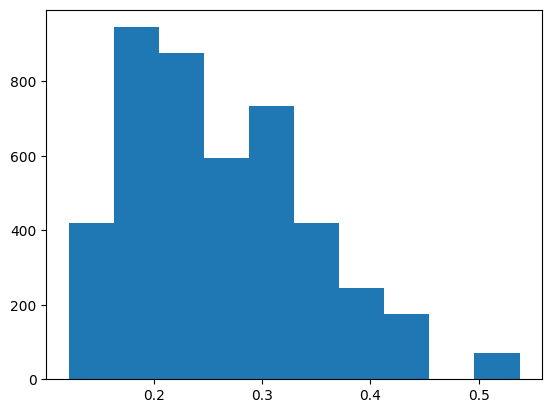

In [ ]:
plt.hist(all_results['lab_var'])

In [104]:
results_copy = all_results.reset_index().copy()
results_copy.loc[results_copy['p_value']>0.05, 'coeffs'] = 0 
results_copy = results_copy.loc[results_copy['converged']]
results_copy['mouse_name'] = results_copy['index'].str.extract(r'T\.(.*?)\]')[0]

In [105]:
coeffs = results_copy.pivot(index=['index', 'mouse_name'], columns=['syl'], values='coeffs').reset_index().dropna().drop(columns=['index'])
coeffs_array = np.array(coeffs.drop(columns='mouse_name')[:38])

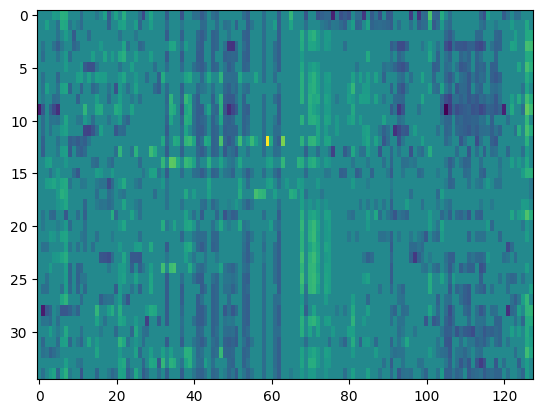

In [101]:
plt.imshow(coeffs_array, aspect='auto')

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_18499/2690044994.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('Greys')


(0.0, 35.0)

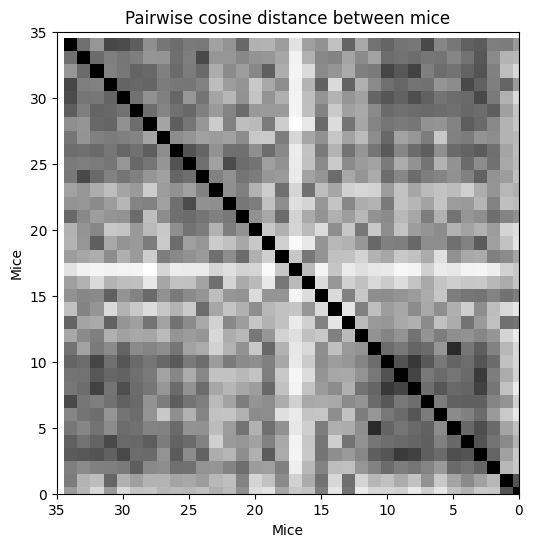

In [73]:
pairwise_matrix = pairwise_distances(coeffs_array, metric='cosine')
palette=sns.color_palette('Greys', as_cmap=True)
orig_map=plt.cm.get_cmap('Greys')
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

fig, ax = plt.subplots(figsize=[10, 6])
plt.imshow(pairwise_matrix, cmap=reversed_map)
plt.xlabel('Mice')
plt.ylabel('Mice')
plt.title('Pairwise cosine distance between mice')
plt.xlim([np.shape(pairwise_matrix)[0], 0])
plt.ylim([0, np.shape(pairwise_matrix)[0]])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7204/448238393.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(pairwise_matrix.copy(), method='complete', metric='cosine')  # You can also try 'complete', 'ward', etc.


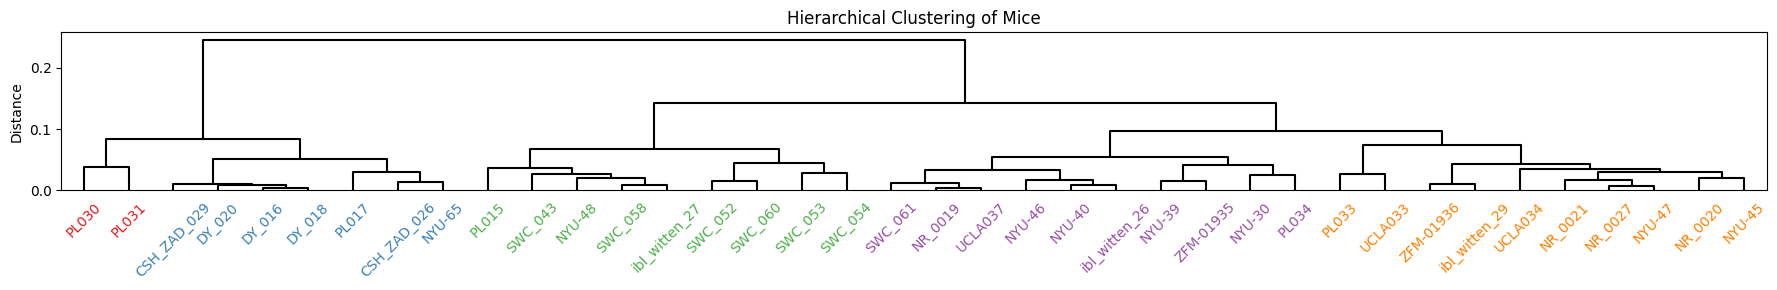

In [300]:
k = 5
mouse_labels = data['mouse_name'].unique()
from scipy.cluster.hierarchy import linkage, dendrogram
# Perform clustering
Z = linkage(pairwise_matrix.copy(), method='complete', metric='cosine')  # You can also try 'complete', 'ward', etc.

# Z = linkage(pairwise_matrix.copy(), method='average', metric='cosine')  # You can also try 'complete', 'ward', etc.

from scipy.cluster.hierarchy import ward, fcluster
# final_clusters = fcluster(Z, t=k, criterion='maxclust')
final_clusters = fcluster(Z, t=k, criterion='maxclust')
final_clusters = final_clusters - 1

mouse_labels = np.array(coeffs['mouse_name'][:38])

# Plot dendrogram
fig, ax = plt.subplots(figsize=(18, 3))

# Define colors for clusters
cmap = plt.get_cmap(sns.color_palette("Set1", k, as_cmap=True))
# cmap = plt.get_cmap(sns.color_palette(k, as_cmap=True))
colors = [cmap(i % cmap.N) for i in range(k)]
cluster_colors = {i: colors[i] for i in range(k)}

# Plot dendrogram with colored labels
dendro = dendrogram(Z, labels=mouse_labels, leaf_font_size=10, ax=ax, 
                    link_color_func=lambda k: "black", leaf_rotation=45)

# Apply colors to tick labels
x_labels = ax.get_xmajorticklabels()
counter = 0
for lbl in x_labels:
    mouse_id = lbl.get_text()
    cluster_id = final_clusters[mouse_labels==mouse_id][0]
    lbl.set_color(cluster_colors[cluster_id])

plt.title("Hierarchical Clustering of Mice")
plt.ylabel("Distance")
plt.tight_layout()

plt.show()


In [301]:
plot_coeffs = coeffs[:38]
plot_coeffs['cluster'] = final_clusters
plot_coeffs = plot_coeffs.sort_values('cluster')

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7204/3833343961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_coeffs['cluster'] = final_clusters


In [302]:
plot_coeffs.to_parquet(prefix + 'representation_learning_variability/paper-individuality/fig5_mixed_models/5_mouse_cluster_coef_lab', compression='gzip') 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


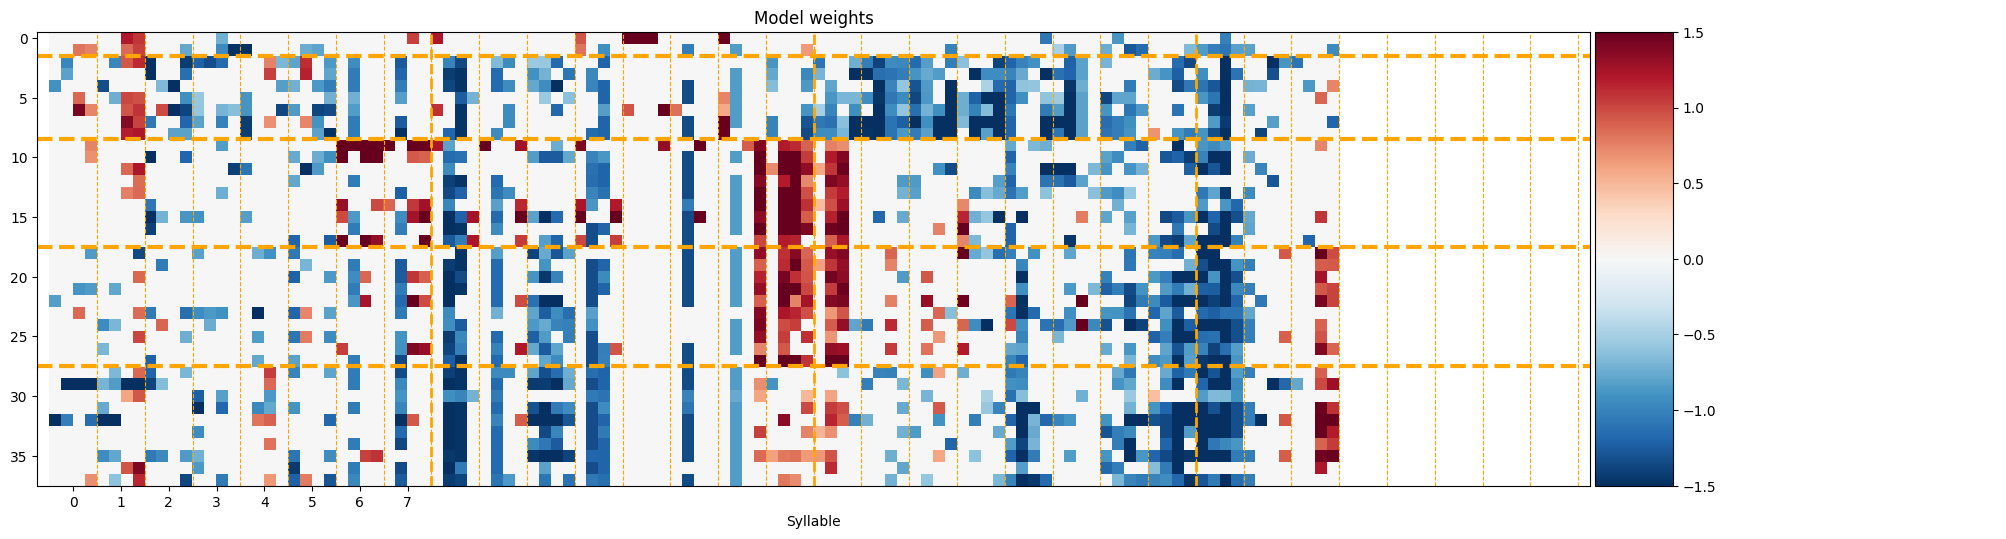

In [292]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

syllable_labels = ['000', '100', '200', '300', '400', '500', '600', '700',
                   '010', '110', '210', '310', '410', '510', '610', '710',
                   '001', '101', '201', '301', '401', '501', '601', '701',
                   '011', '111', '211', '311', '411', '511', '611', '711']
# plot weights for phase and individual identity
fig, ax = plt.subplots()
fig.set_size_inches(20,16)

plt_coefs = np.array(plot_coeffs.drop(columns=['mouse_name', 'cluster'])).astype(float)
plt.imshow(plt_coefs, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
plt.title('Model weights')
ax = plt.gca()
plt.axhline(np.where(np.diff(plot_coeffs['cluster'])==1)[0][0] - 0.5+1, c='orange', ls='--', lw=3)
plt.axhline(np.where(np.diff(plot_coeffs['cluster'])==1)[0][1] - 0.5+1, c='orange', ls='--', lw=3)
plt.axhline(np.where(np.diff(plot_coeffs['cluster'])==1)[0][2] - 0.5+1, c='orange', ls='--', lw=3)
plt.axhline(np.where(np.diff(plot_coeffs['cluster'])==1)[0][3] - 0.5+1, c='orange', ls='--', lw=3)
# plt.axhline(np.where(np.diff(mouse_coefs['mouse_cluster'])==1)[0][4] - 0.5+1, c='k', ls='--', lw=1)
plt.axvline(32-0.5, c='orange', ls='--', lw=2)
plt.axvline(32*2 - 0.5, c='orange', ls='--', lw=2)
plt.axvline(32*3 - 0.5, c='orange', ls='--', lw=2)
for i in range(32):
    plt.axvline(4*(i+1)-0.5, c='orange', ls='--', lw=.8)


plt.xlim(-1.5, y.shape[1] + 0.5)
# plt.xticks(np.arange(0, 32*4, 1), syllable_labels*4)
plt.xticks(np.arange(16, 16*8, 32)-0.5, ['No whisk/Lick', 'Whisk only', 'Lick only', 'Whisk+Lick'])
plt.xticks([1.5, 1.5+4, 1.5+2*4, 1.5+4*3, 1.5+4*4, 1.5+4*5, 1.5+4*6, 1.5+4*7], [0, 1, 2, 3, 4, 5, 6, 7])

# plt.xticks(np.arange(8, 47, 5), np.arange(0, 39, 5))
# plt.yticks(np.arange(0, len(coeffs_array), 1), coeffs_array['mouse_name'])
plt.xlabel('Syllable')
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.25, 1))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.tight_layout()

In [723]:
print(res.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      syll        
No. Observations:      113345       Method:                  REML        
No. Groups:            180          Scale:                   0.9986      
Min. group size:       372          Log-Likelihood:          -161128.2789
Max. group size:       1521         Converged:               No          
Mean group size:       629.7                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      -0.039    0.136 -0.286 0.775 -0.306  0.228
C(trial_type)[T.0.0right]      -0.004    0.015 -0.281 0.779 -0.033  0.025
C(trial_type)[T.1.0left]       -0.003    0.011 -0.239 0.811 -0.024  0.019
C(trial_type)[T.1.0right]      -0.003    0.011 -0.288 0.

In [ ]:
total_var = var_mouse + var_lab + var_resid
icc_mouse = var_mouse / total_var
icc_lab = var_lab / total_var
icc_mouse_lab = (var_mouse + var_lab) / total_var

In [724]:
results_copy = all_results.copy()
results_copy.loc[results_copy['p_value']> 0.05, 'coeffs'] = 0  # Zero non-significant coefficients
results_copy = results_copy.loc[results_copy['converged']==True]  # Remove non converged model results
results_copy = results_copy.reset_index()


In [651]:
pivot_1 = results_copy.reset_index().pivot(index=['index'], columns=['syllable'], values='coeffs').reset_index().dropna()
pivot_1['trial_type'] = pivot_1['index'].str.extract(r'C\(trial_type\)(.*?)C\(mouse_name\)')
pivot_1['mouse_name'] = pivot_1['index'].str.extract(r'C\(mouse_name\)\[(.*?)\]')
pivot_1 = pivot_1.loc[pivot_1['index']!='Intercept']

In [665]:
trial_types = pivot_1['trial_type'].unique()
full_df = pivot_1.loc[pivot_1['trial_type'].isna()]
for i, type in enumerate(['[T.0.0right]:', '[T.1.0left]:', '[T.1.0right]:']):
    use = pivot_1.loc[pivot_1['trial_type']==type]
    # use = np.array(use.drop(columns=['index', 'trial_type', 'mouse_name']).astype(float))
    full_df = full_df.merge(use, on=['mouse_name'])
    # full_df = full_df.drop(columns=['index', 'trial_type', 'mouse_name']).astype(float)
    # full_df =  np.concatenate([full_df, use], axis=1)

mouse_coeffs_array = np.array(full_df)

MergeError: Passing 'suffixes' which cause duplicate columns {'4.0Choice_x', '17.0ITI_x', '5.0Quiescence_x', '2.0Choice_x', '4.0ITI_x', '1.0Pre-quiescence_x', '0.0Choice_x', '14.0ITI_x', '27.0ITI_x', '29.0Quiescence_x', '0.0Pre-quiescence_x', '28.0Pre-quiescence_x', '19.0Choice_x', '17.0Choice_x', '30.0Quiescence_x', '12.0Choice_x', '20.0ITI_x', '6.0ITI_x', '13.0Choice_x', '0.0Quiescence_x', '5.0Pre-quiescence_x', '11.0ITI_x', '6.0Pre-quiescence_x', '23.0ITI_x', '18.0ITI_x', '3.0Choice_x', '31.0Pre-quiescence_x', '8.0ITI_x', '30.0ITI_x', '8.0Pre-quiescence_x', '11.0Pre-quiescence_x', '30.0Choice_x', '14.0Choice_x', '27.0Pre-quiescence_x', '29.0Choice_x', '6.0Quiescence_x', '16.0ITI_x', '2.0Pre-quiescence_x', '22.0ITI_x', '15.0ITI_x', '9.0Pre-quiescence_x', '15.0Choice_x', '16.0Choice_x', '25.0ITI_x', '27.0Choice_x', 'index_x', '31.0Choice_x', '14.0Pre-quiescence_x', '5.0ITI_x', '4.0Pre-quiescence_x', '3.0ITI_x', '7.0Choice_x', '30.0Pre-quiescence_x', '26.0Quiescence_x', '11.0Quiescence_x', '21.0Choice_x', '9.0Quiescence_x', '20.0Choice_x', '31.0ITI_x', '3.0Quiescence_x', '22.0Choice_x', '10.0Quiescence_x', '16.0Quiescence_x', '3.0Pre-quiescence_x', '8.0Choice_x', '24.0ITI_x', '15.0Pre-quiescence_x', '5.0Choice_x', '11.0Choice_x', '9.0ITI_x', '12.0Quiescence_x', '27.0Quiescence_x', '25.0Choice_x', '24.0Quiescence_x', '28.0Quiescence_x', '25.0Pre-quiescence_x', '29.0ITI_x', '2.0Quiescence_x', '6.0Choice_x', '13.0ITI_x', '18.0Choice_x', '28.0ITI_x', '18.0Pre-quiescence_x', '2.0ITI_x', '10.0Pre-quiescence_x', '1.0Choice_x', '10.0Choice_x', '12.0ITI_x', '24.0Pre-quiescence_x', '12.0Pre-quiescence_x', '26.0Choice_x', '29.0Pre-quiescence_x', '15.0Quiescence_x', '26.0Pre-quiescence_x', '16.0Pre-quiescence_x', '22.0Quiescence_x', 'trial_type_x', '13.0Pre-quiescence_x', '26.0ITI_x', '17.0Pre-quiescence_x', '0.0ITI_x', '28.0Choice_x', '8.0Quiescence_x', '24.0Choice_x', '4.0Quiescence_x', '1.0ITI_x', '1.0Quiescence_x', '25.0Quiescence_x', '14.0Quiescence_x', '9.0Choice_x', '10.0ITI_x'} is not allowed.

In [694]:
mouse_coeffs_array = np.array(use.drop(columns=['index', 'trial_type', 'mouse_name']))

In [741]:
mouse_coeffs = results_copy.reset_index().pivot(index=['index'], columns=['syllable'], values='coeffs').reset_index().dropna()[:-4]

mouse_coeffs_array = np.array(mouse_coeffs.drop(columns=['index']).astype(float))

In [742]:
mouse_coeffs['trial_type'] = mouse_coeffs['index'].str.extract(r'C\(trial_type\)\[T\.(.*?)\]')
mouse_coeffs['mouse_name'] = mouse_coeffs['index'].str.extract(r'C\(mouse_name\)\[(.*?)\]')

## Clustering

/tmp/ipykernel_9928/1883941004.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



(0.0, 38.0)

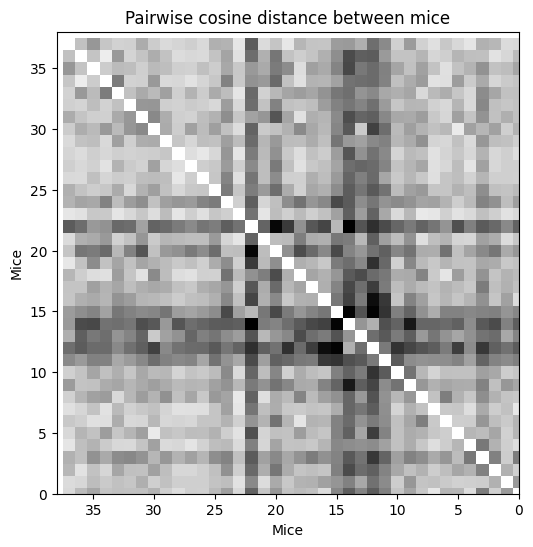

In [743]:
pairwise_matrix = pairwise_distances(mouse_coeffs_array, metric='cosine')

# plt.yticks(np.arange(0, len(mouse_labels)), np.array(mouse_labels))

palette=sns.color_palette('Greys', as_cmap=True)
orig_map=plt.cm.get_cmap('Greys')
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

fig, ax = plt.subplots(figsize=[10, 6])
plt.imshow(pairwise_matrix, cmap=orig_map)
plt.xlabel('Mice')
plt.ylabel('Mice')
plt.title('Pairwise cosine distance between mice')
plt.xlim([np.shape(pairwise_matrix)[0], 0])
plt.ylim([0, np.shape(pairwise_matrix)[0]])

In [739]:
mouse_coeffs = use.reset_index().copy()

/tmp/ipykernel_9928/3282341504.py:10: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



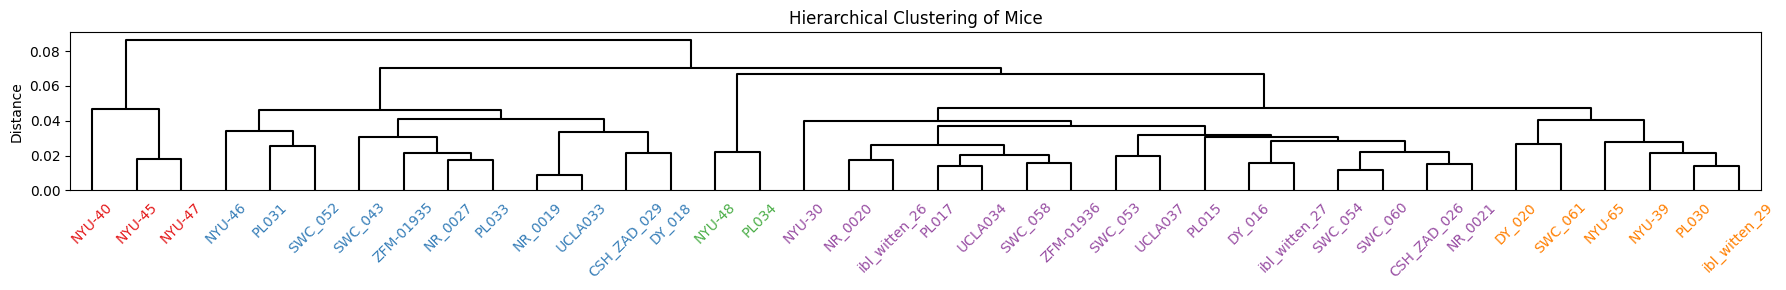

In [744]:
k = 5
mouse_names = mouse_coeffs['index'].str.extract(r'T\.(.*?)\]')[0]
mouse_labels = np.array(mouse_names)

# mouse_labels = np.array(use['mouse_name'])

from scipy.cluster.hierarchy import linkage, dendrogram
# Perform clustering
p = pairwise_matrix
Z = linkage(p.copy(), method='average', metric='cosine')  # You can also try 'complete', 'ward', etc.

# Z = linkage(pairwise_matrix.copy(), method='average', metric='cosine')  # You can also try 'complete', 'ward', etc.

from scipy.cluster.hierarchy import ward, fcluster
# final_clusters = fcluster(Z, t=k, criterion='maxclust')
final_clusters = fcluster(Z, t=k, criterion='maxclust')
final_clusters = final_clusters - 1

# mouse_labels = np.array(full_session_syllables['mouse_name'])#.unique()
# design_df['session_cluster'] = clusters 

# Plot dendrogram
fig, ax = plt.subplots(figsize=(18, 3))

# Define colors for clusters
cmap = plt.get_cmap(sns.color_palette("Set1", k, as_cmap=True))
# cmap = plt.get_cmap(sns.color_palette(k, as_cmap=True))
colors = [cmap(i % cmap.N) for i in range(k)]
cluster_colors = {i: colors[i] for i in range(k)}

# Plot dendrogram with colored labels
dendro = dendrogram(Z, labels=mouse_labels, leaf_font_size=10, ax=ax, 
                    link_color_func=lambda k: "black", leaf_rotation=45)

# Apply colors to tick labels
x_labels = ax.get_xmajorticklabels()
counter = 0
for lbl in x_labels:
    mouse_id = lbl.get_text()
    cluster_id = final_clusters[mouse_labels==mouse_id][0]
    lbl.set_color(cluster_colors[cluster_id])

plt.title("Hierarchical Clustering of Mice")
plt.ylabel("Distance")
plt.tight_layout()

plt.show()

In [720]:
mouse_coeffs['mouse_clusters'] = final_clusters
mouse_coeffs = mouse_coeffs.sort_values(by='mouse_clusters')

In [692]:
mouse_coeffs = use.copy()
mouse_coeffs['mouse_clusters'] = final_clusters
mouse_coeffs = mouse_coeffs.sort_values(by='mouse_clusters')

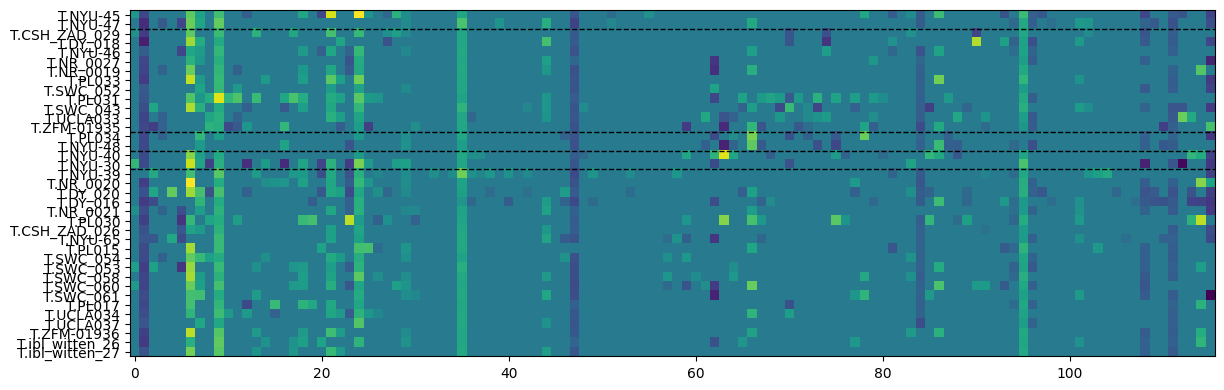

In [721]:
# plot_coeffs = np.array(mouse_coeffs.drop(columns=['index', 'mouse_clusters']).astype(float))
plot_coeffs = mouse_coeffs_array

fig, ax = plt.subplots()
fig.set_size_inches(14,10)
plt.imshow(plot_coeffs)
labels = mouse_coeffs['index'].str.extract(r'T\.(.*?)\]')[0]
labels = np.array(mouse_coeffs['mouse_name'])
plt.yticks(np.arange(0, len(labels), 1), np.array(labels))
plt.axhline(np.where(np.diff(mouse_coeffs['mouse_clusters'])==1)[0][0] - 0.5+1, c='k', ls='--', lw=1)
plt.axhline(np.where(np.diff(mouse_coeffs['mouse_clusters'])==1)[0][1] - 0.5+1, c='k', ls='--', lw=1)
plt.axhline(np.where(np.diff(mouse_coeffs['mouse_clusters'])==1)[0][2] - 0.5+1, c='k', ls='--', lw=1)
plt.axhline(np.where(np.diff(mouse_coeffs['mouse_clusters'])==1)[0][3] - 0.5+1, c='k', ls='--', lw=1)


# PCA

In [360]:
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.decomposition import PCA

In [361]:
X = np.array(mouse_coeffs_array)

In [362]:
n_components = 30
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
standardized_X = scaler.fit_transform(X)
# X_pca = pca.fit_transform(standardized_X)
X_pca = pca.fit_transform(X)

Text(0.5, 1.0, 'Explained Variance by PCA')

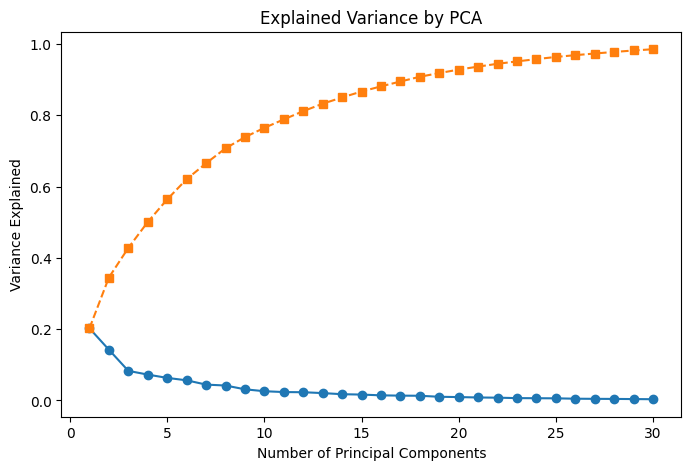

In [363]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

In [364]:
np.shape(X_pca)

(38, 30)

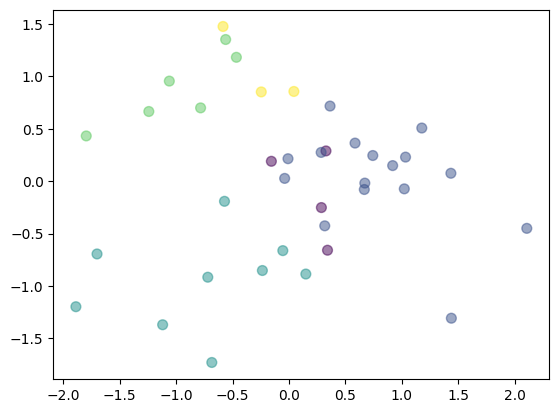

In [365]:
clusters = np.array(final_clusters)

plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, marker='o', s=50, 
         c=clusters)
# plt.xlim([-10, 10])
# plt.ylim([-10, 10])

# plt.scatter(X_pca[:, 1], size=1)


In [167]:
import plotly.graph_objects as go

# Create trace, sizing bubbles by planet diameter
fig = go.Figure(data=go.Scatter3d(
    x = X_pca[:, 0],
    y = X_pca[:, 1],
    z = X_pca[:, 2],
    mode = 'markers',
    marker = dict(
        color = final_clusters,
        )
))
fig.show()

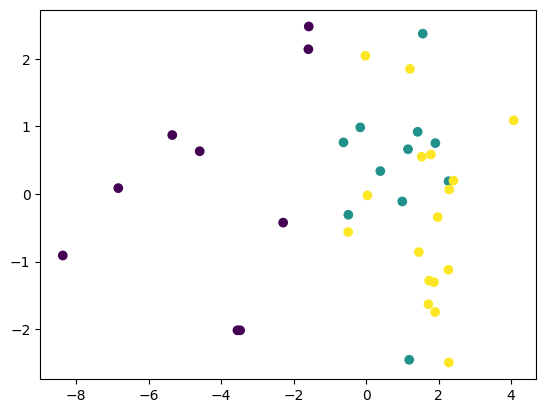

In [168]:
cmap = plt.get_cmap(sns.color_palette("tab10", k, as_cmap=True))
# cmap = plt.get_cmap(sns.color_palette(k, as_cmap=True))
colors = [cmap(i % cmap.N) for i in range(k)]
cluster_colors = {i: colors[i] for i in range(k)}
plt.scatter(X_pca[:, 0], X_pca[:, 4], c=final_clusters)